**Contexto** Una empresa de alquiler de DVD quiere averiguar durante cuántos días alquilará un cliente un DVD basándose en algunas características. 
La empresa quiere un modelo que produzca un MSE de 3 o menos en un conjunto de prueba. 
Se espera que su modelo ayude a la empresa a ser más eficiente en la planificación de inventarios.

Los datos que han proporcionado están en el archivo csv `rental_info.csv`. 

Tiene las siguientes características:

- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

**Guía**:

1. Obtener el número de días de alquiler.

2. Categorización (dummy) y normalización de variables.

3. División entrenamiento-prueba.

4. Selección de características(?)

5. Elección de modelos y ajuste de hiperparámetros

6. Predicción de valores en el conjunto de pruebas

7. Cálculo del error cuadrático medio

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
# Exportar la data:
df_rental = pd.read_csv('rental_info.csv')
df_rental.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [3]:
# Resumen de las variables del dataframe.
df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [4]:
# Descripción estadística de las variables númericas del dataframe.
df_rental.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


In [5]:
# Convertir las columnas de fecha a tipo datetime

df_rental['rental_date'] = pd.to_datetime(df_rental['rental_date'])
df_rental['return_date'] = pd.to_datetime(df_rental['return_date'])

In [6]:
# Se confirma que hayan quedado tipo fecha
df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

In [7]:
# Crear variable days_rented
df_rental['days_rented'] = (df_rental['return_date'] - df_rental['rental_date']).dt.days
df_rental['days_rented']

0        3
1        2
2        7
3        2
4        4
        ..
15856    6
15857    4
15858    9
15859    8
15860    6
Name: days_rented, Length: 15861, dtype: int64

In [8]:
df_rental.columns

Index(['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate',
       'length', 'replacement_cost', 'special_features', 'NC-17', 'PG',
       'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2', 'days_rented'],
      dtype='object')

In [9]:
# Dividamos las variables en categoricas y numericas:

numericas = ['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate', 'length', 'replacement_cost', 'amount_2', 'length_2',
             'rental_rate_2', 'days_rented']

categoricas = ['special_features', 'NC-17', 'PG', 'PG-13', 'R']

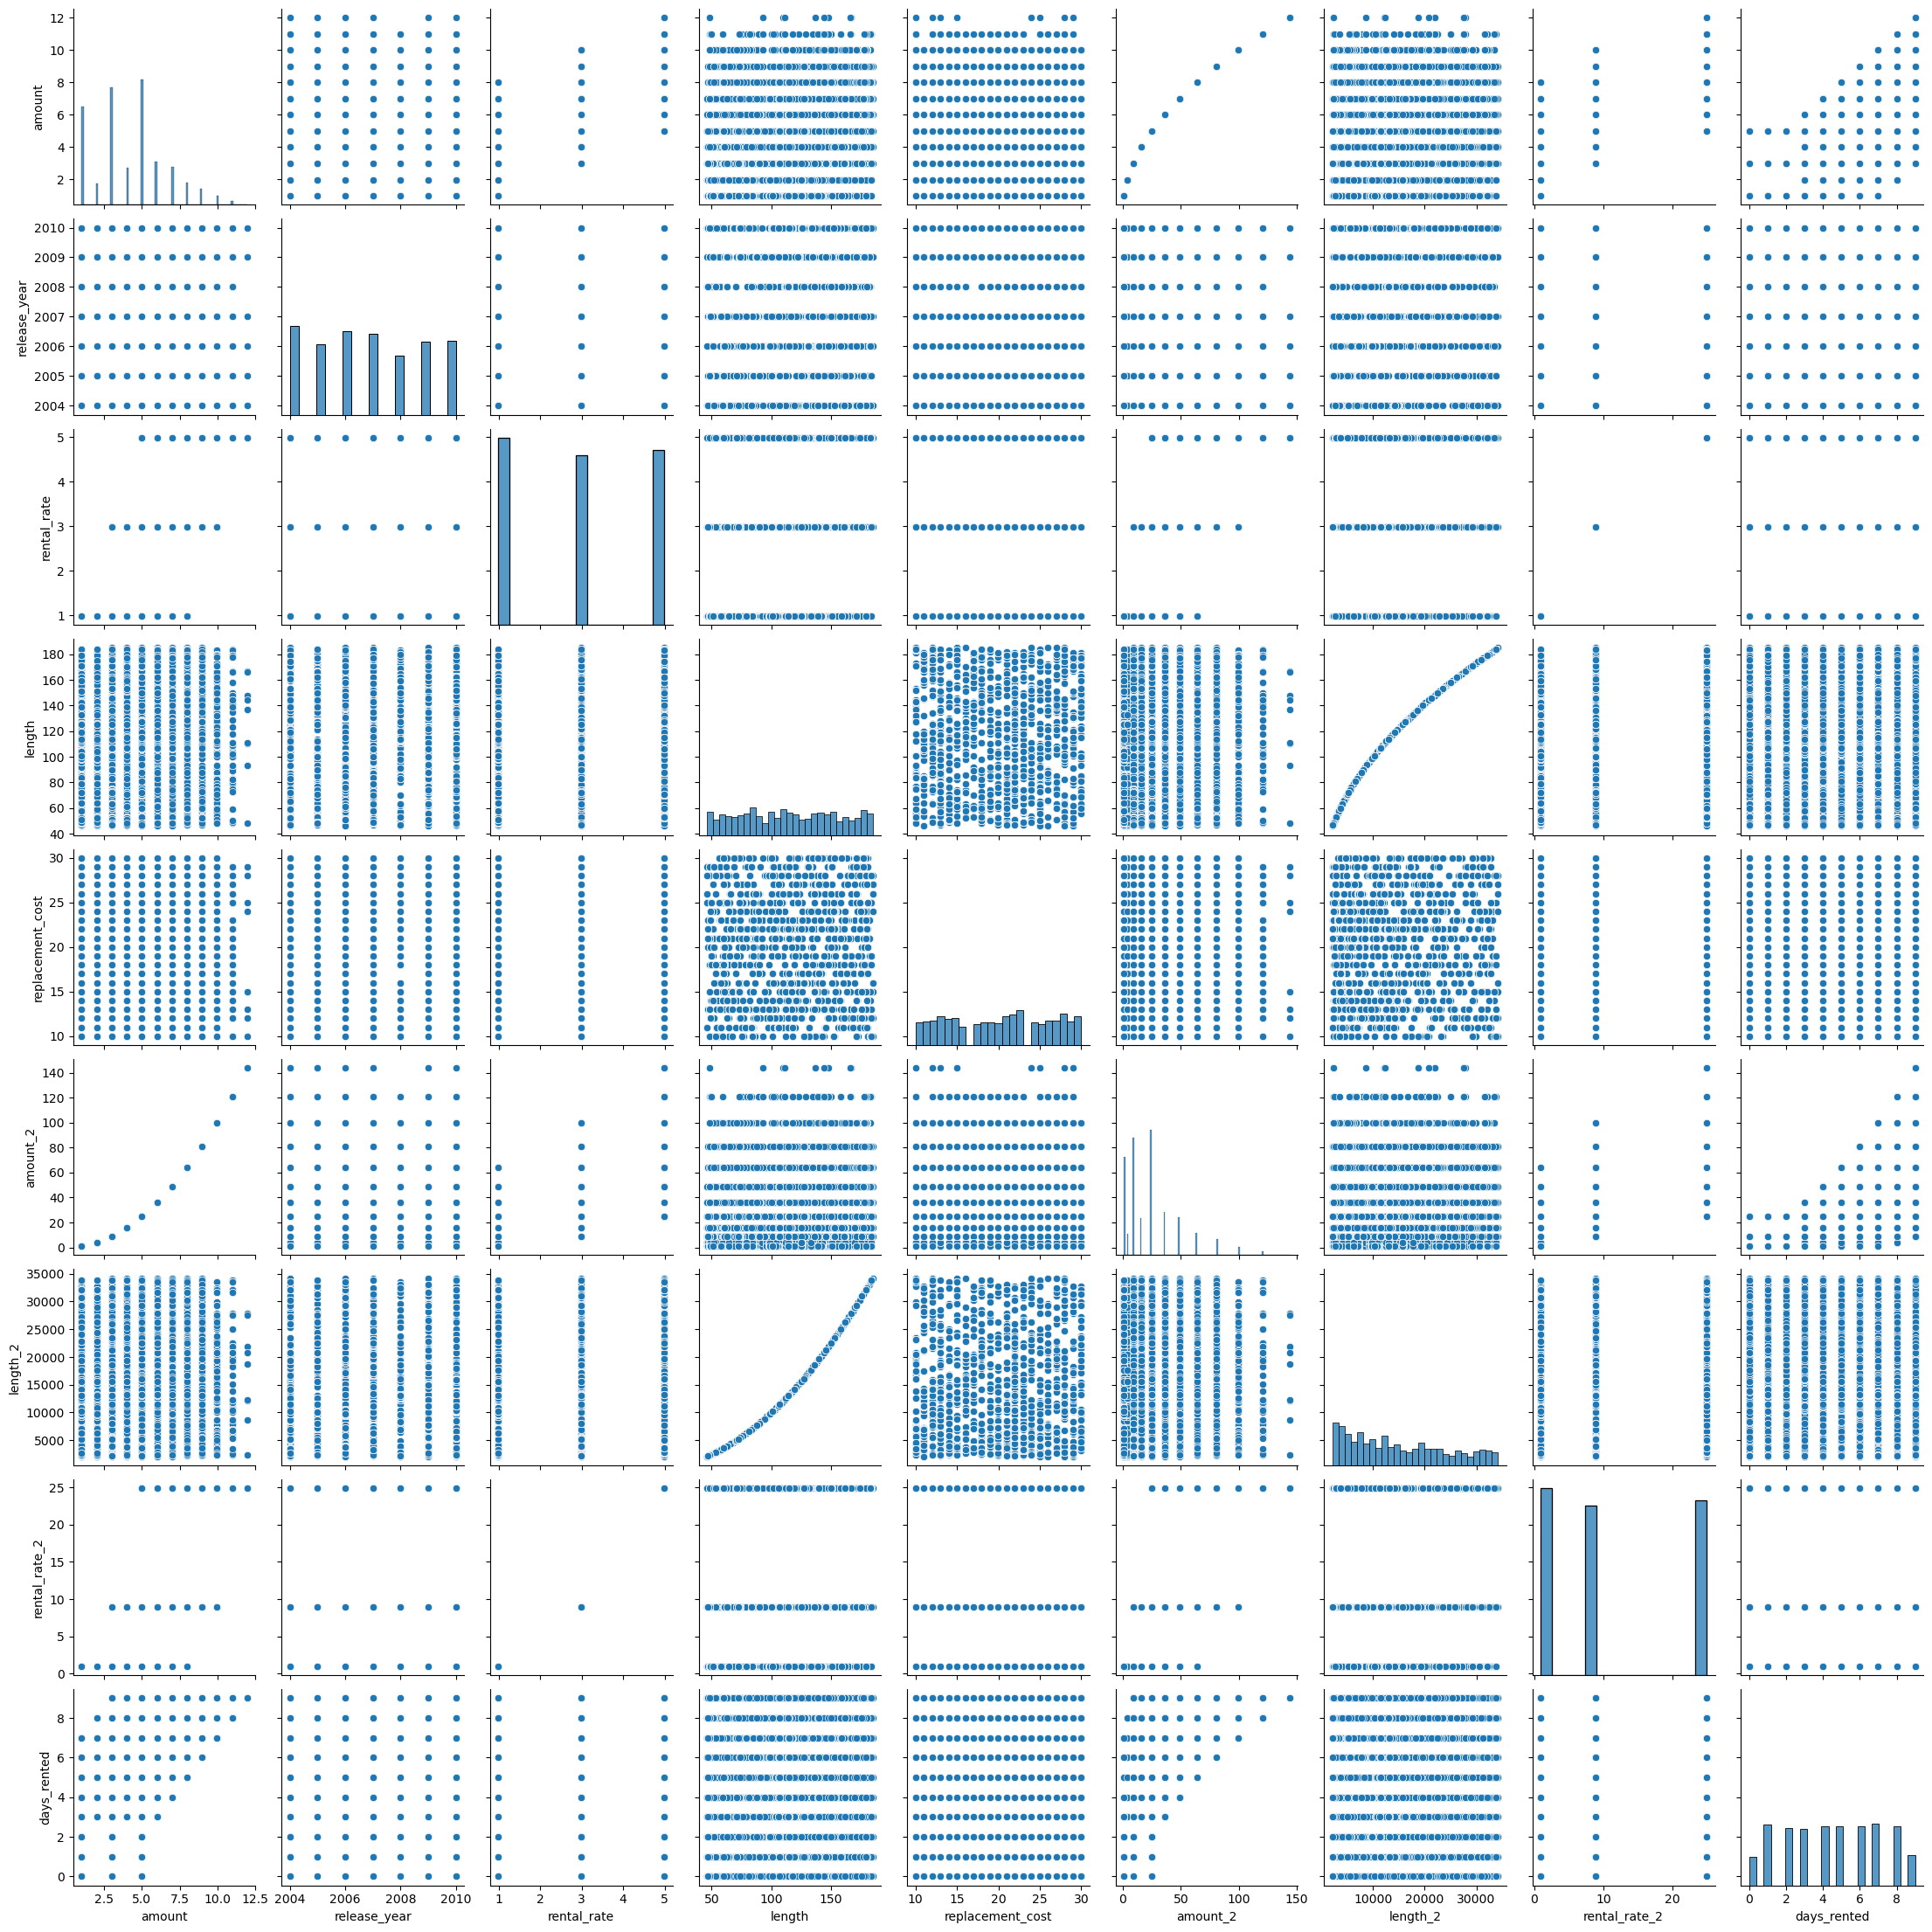

In [10]:
sns.pairplot(data=df_rental[numericas], kind = 'scatter')
plt.show()

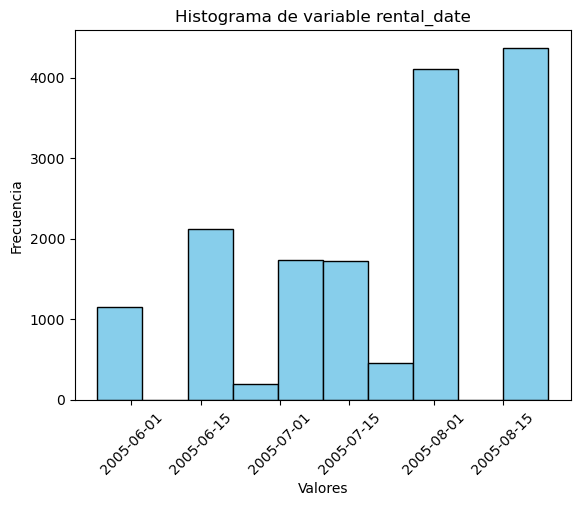

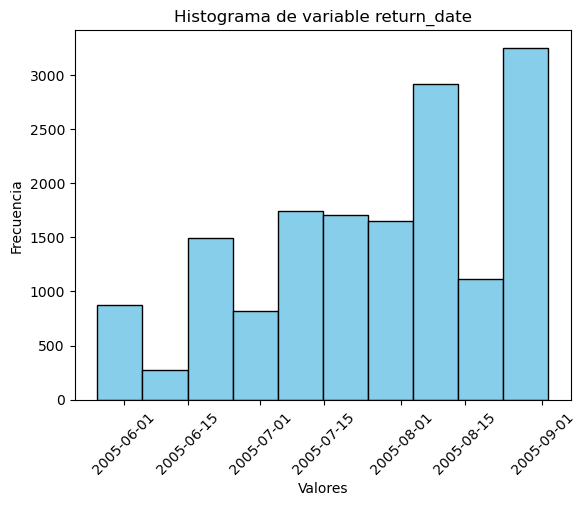

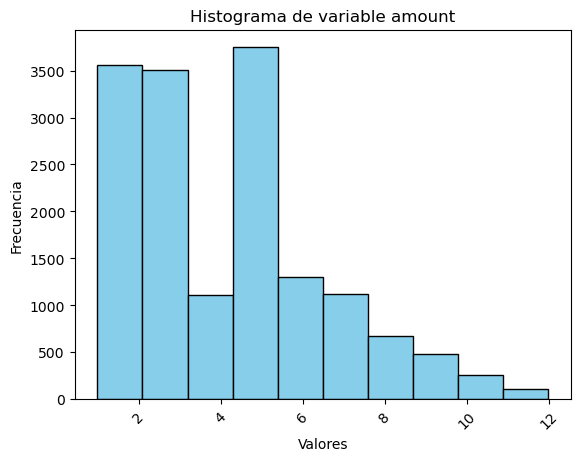

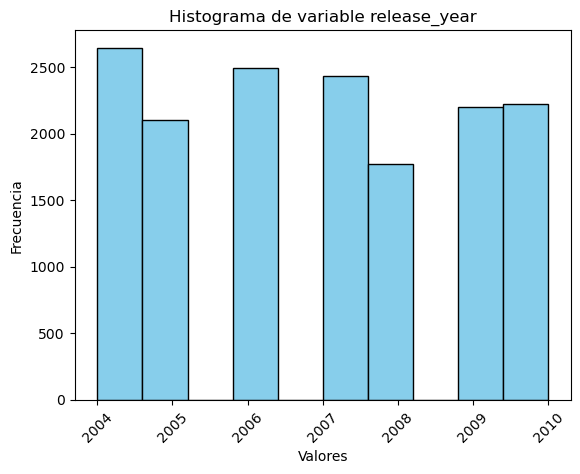

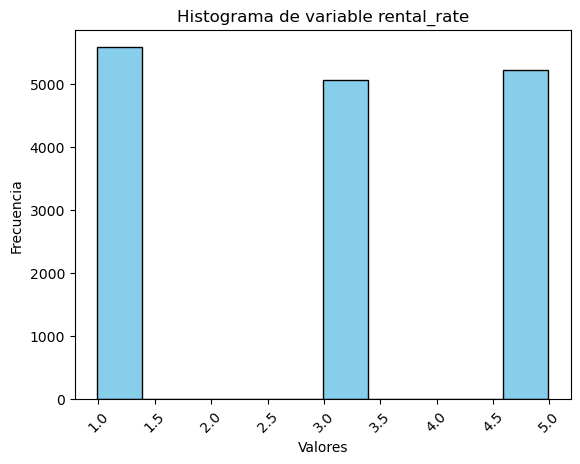

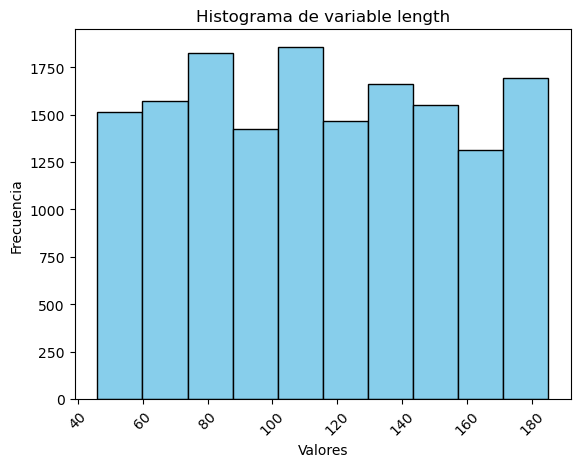

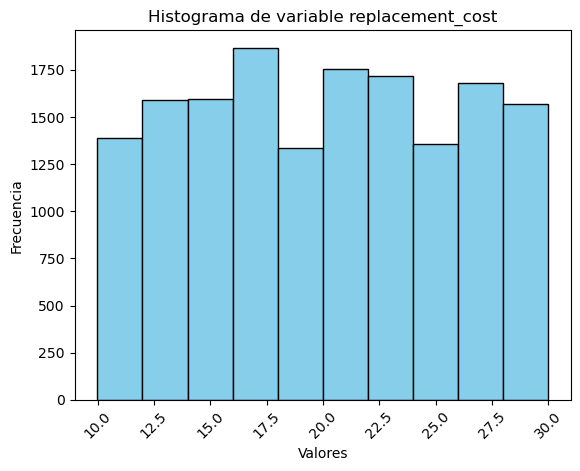

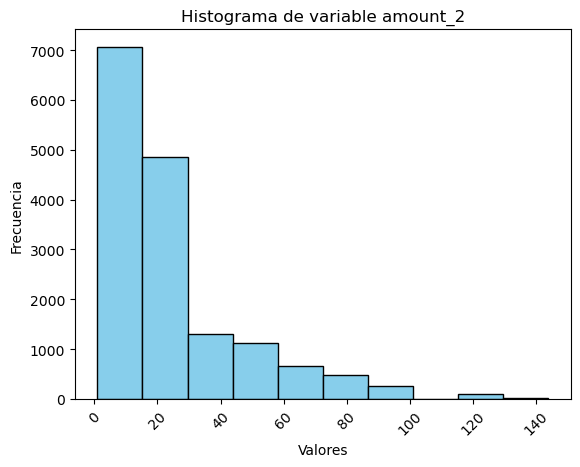

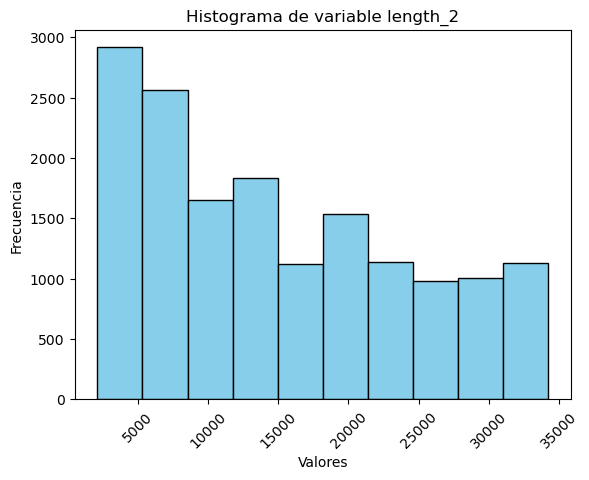

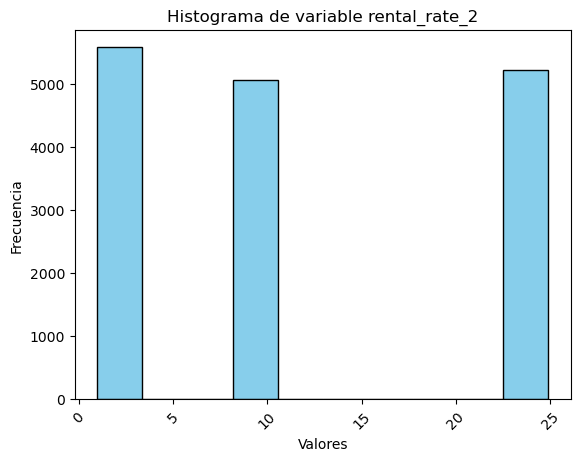

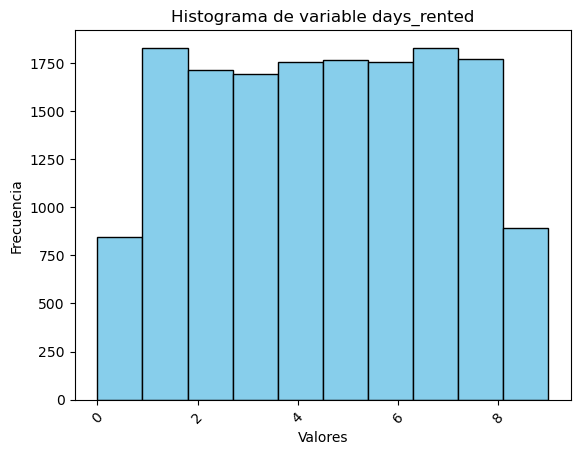

In [11]:
# Se realiza un ciclo for para generar un histograma por cada una de las variables no categoricas.

for col in df_rental[numericas].columns:
    # Crear el histograma
    plt.hist(df_rental[col], color='skyblue', edgecolor='black')  
    plt.title(f"Histograma de variable {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45) 
    plt.show()

In [12]:
# Contar los valores para cada variable:
for col in categoricas:
    print(df_rental[col].value_counts().sort_index())

special_features
{"Behind the Scenes"}                                           1108
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Behind the Scenes"}                              1078
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries,"Deleted Scenes"}                                 1011
{Commentaries}                                                  1089
{Trailers,"Behind the Scenes"}                                  1122
{Trailers,"Deleted Scenes","Behind the Scenes"}                  772
{Trailers,"Deleted Scenes"}                                     1047
{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,Commentaries}                                         1129
{Trailers}       

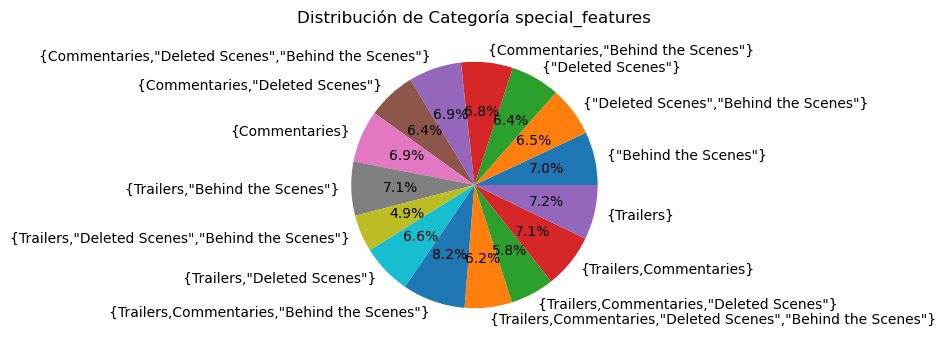

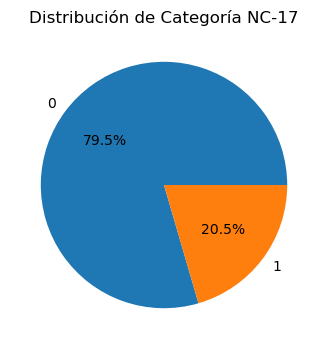

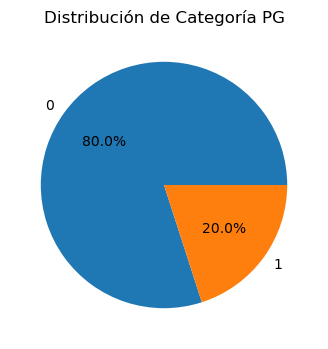

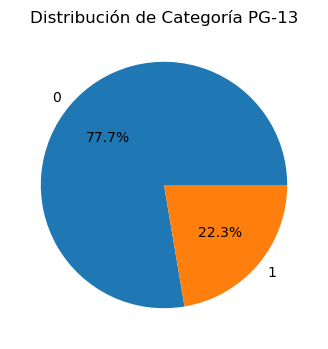

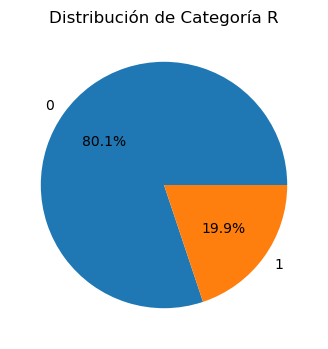

In [13]:
# Se realiza un ciclo for para generar un gráfico de torta para . 
# Crear el gráfico de torta
for col in categoricas:
    df = df_rental[col].value_counts().sort_index()
    plt.figure(figsize=(4, 4))  # Tamaño del gráfico
    plt.pie(df, labels=df.index, autopct='%1.1f%%')
    plt.title(f"Distribución de Categoría {col}")  
    plt.show()

Respecto a la variable special features. Esta es categorica con muchos valores diferentes, lo cual hace que sea muy dificil tenerla en cuenta dentro del modelo.

Sin embargo, a través del código podríamos descomprimir esta variable.

In [14]:
c = 0
lista_palabras = []
for i in df_rental['special_features']:
    i = i.replace('{', '')
    i = i.replace('}', '')
    i = i.replace('"', '')
    lista = i.split(',')
    lista_palabras += lista
    df_rental['special_features'][c] = lista
    c += 1

print(lista_palabras)
print(set(lista_palabras))

['Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers', 'Behind the Scenes', 'Trailers

In [15]:
df_rental['special_features']

0                        [Trailers, Behind the Scenes]
1                        [Trailers, Behind the Scenes]
2                        [Trailers, Behind the Scenes]
3                        [Trailers, Behind the Scenes]
4                        [Trailers, Behind the Scenes]
                             ...                      
15856    [Trailers, Deleted Scenes, Behind the Scenes]
15857    [Trailers, Deleted Scenes, Behind the Scenes]
15858    [Trailers, Deleted Scenes, Behind the Scenes]
15859    [Trailers, Deleted Scenes, Behind the Scenes]
15860    [Trailers, Deleted Scenes, Behind the Scenes]
Name: special_features, Length: 15861, dtype: object

Como podemos observar, la columna special features es una combinación de cuatro valores, los cuales serían: {'Commentaries', 'Behind the Scenes', 'Deleted Scenes', 'Trailers'}. Teniendo en cuenta esto, podemos crear una columna 



In [16]:
# Crear la nueva columna con 0 o 1
df_rental['Trailers'] = df_rental['special_features'].apply(lambda x: 1 if 'Trailers' in x else 0)
df_rental['Behind_the_Scenes'] = df_rental['special_features'].apply(lambda x: 1 if 'Behind the Scenes' in x else 0)
df_rental['Deleted_Scenes'] = df_rental['special_features'].apply(lambda x: 1 if 'Deleted Scenes' in x else 0)
df_rental['Commentaries'] = df_rental['special_features'].apply(lambda x: 1 if 'Commentaries' in x else 0)

df_rental[['special_features', 'Trailers', 'Behind_the_Scenes', 'Deleted_Scenes', 'Commentaries']]

,special_features,Trailers,Behind_the_Scenes,Deleted_Scenes,Commentaries
0,"[Trailers, Behind the Scenes]",1,1,0,0
1,"[Trailers, Behind the Scenes]",1,1,0,0
2,"[Trailers, Behind the Scenes]",1,1,0,0
3,"[Trailers, Behind the Scenes]",1,1,0,0
4,"[Trailers, Behind the Scenes]",1,1,0,0
...,...,...,...,...,...
15856,"[Trailers, Deleted Scenes, Behind the Scenes]",1,1,1,0
15857,"[Trailers, Deleted Scenes, Behind the Scenes]",1,1,1,0
15858,"[Trailers, Deleted Scenes, Behind the Scenes]",1,1,1,0
15859,"[Trailers, Deleted Scenes, Behind the Scenes]",1,1,1,0


In [17]:
# Se borra la variable special_features
df_rental.drop('special_features', axis=1, inplace=True)

# Teniendo en cuenta que ya todas las variables están escritas en términos númericos, se saca la matrix de correlación para seleccionar las variables a 
# utilizar dentro del modelo.
df_rental.corr()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,days_rented,Trailers,Behind_the_Scenes,Deleted_Scenes,Commentaries
rental_date,1.000000,0.995095,0.012492,-0.004638,0.005681,-0.000270,0.003921,0.003149,0.007233,-0.005141,-0.002499,0.012957,-0.000271,0.003211,0.006699,0.006935,0.005698,-0.006996,-0.000587
return_date,0.995095,1.000000,0.067559,-0.003941,0.005478,-0.000734,0.005595,0.003122,0.006463,-0.004027,-0.003468,0.067761,-0.000741,0.003020,0.104549,0.006719,0.005686,-0.007207,-0.000181
amount,0.012492,0.067559,1.000000,0.021726,0.685870,0.018947,-0.026725,0.003968,-0.010591,0.012773,-0.007029,0.956141,0.017864,0.678597,0.551593,-0.030925,-0.014005,-0.010035,0.019305
release_year,-0.004638,-0.003941,0.021726,1.000000,0.037304,0.031088,0.069991,0.027187,-0.022237,0.027442,-0.052645,0.015941,0.030640,0.025106,0.007044,-0.044379,-0.002617,0.010470,-0.033911
rental_rate,0.005681,0.005478,0.685870,0.037304,1.000000,0.055224,-0.064787,0.036280,0.000174,0.022812,-0.033648,0.587627,0.053390,0.982489,-0.001060,-0.063845,-0.000578,-0.046163,0.030797
length,-0.000270,-0.000734,0.018947,0.031088,0.055224,1.000000,0.026976,-0.030133,-0.049304,0.057023,0.068685,0.015765,0.987667,0.051516,-0.004547,-0.026226,0.006011,-0.000409,0.010433
replacement_cost,0.003921,0.005595,-0.026725,0.069991,-0.064787,0.026976,1.000000,-0.001685,-0.077158,0.044224,0.017768,-0.018281,0.029747,-0.065835,0.015684,-0.024908,0.014281,0.046730,-0.015399
NC-17,0.003149,0.003122,0.003968,0.027187,0.036280,-0.030133,-0.001685,1.000000,-0.254017,-0.272206,-0.252767,0.001186,-0.029444,0.038815,0.000783,-0.006245,0.030828,0.024747,0.080687
PG,0.007233,0.006463,-0.010591,-0.022237,0.000174,-0.049304,-0.077158,-0.254017,1.000000,-0.268408,-0.249240,-0.012859,-0.053299,-0.001420,-0.008066,0.005130,-0.022736,0.057976,-0.012842
PG-13,-0.005141,-0.004027,0.012773,0.027442,0.022812,0.057023,0.044224,-0.272206,-0.268408,1.000000,-0.267087,0.008954,0.062629,0.022525,0.010201,-0.002715,-0.000388,-0.027855,-0.012885


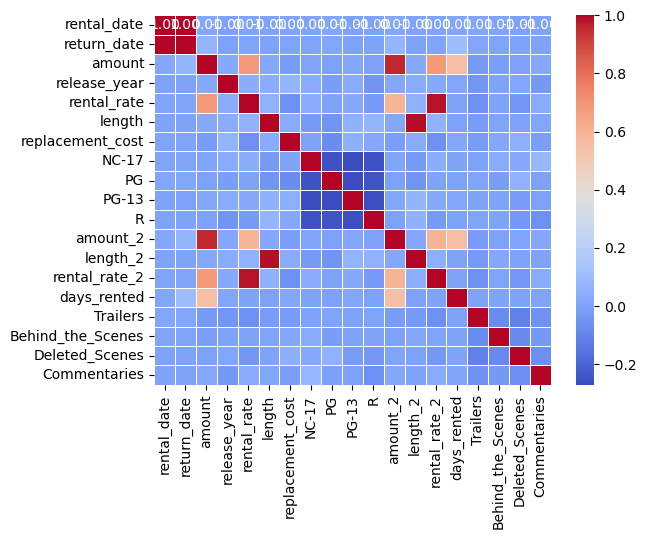

In [18]:
# Realizar un mapa de calor para tener una visual de las correlaciones entre las variables.
sns.heatmap(df_rental.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)
plt.show()

In [19]:
# Se revisa especificamente qué variables tienen mayor correlación con la variable a predecir.
df_rental.corr().days_rented

rental_date          0.006699
return_date          0.104549
amount               0.551593
release_year         0.007044
rental_rate         -0.001060
length              -0.004547
replacement_cost     0.015684
NC-17                0.000783
PG                  -0.008066
PG-13                0.010201
R                   -0.007961
amount_2             0.549412
length_2            -0.004792
rental_rate_2       -0.001258
days_rented          1.000000
Trailers            -0.001359
Behind_the_Scenes   -0.000058
Deleted_Scenes      -0.002615
Commentaries         0.002497
Name: days_rented, dtype: float64

In [20]:
# Teniendo en cuenta que la correlación de las variables respecto de la variable a predecir, se seleccionaran las variables.
# Adicional, la variable de dummys que mayor correlación tiene y la variable de special features que mayor correlación tiene, sea negativa o positiva.
# Las variables a seleccionar serán:

df_rental_reg = df_rental[['return_date', 'amount', 'rental_rate_2', 'replacement_cost', 'PG-13', 'Deleted_Scenes', 'days_rented']]

# Convertir la variable return_date a número
df_rental_reg['return_date'] = df_rental_reg['return_date'].dt.strftime('%Y%m%d').astype(int)

df_rental_reg.head()

,return_date,amount,rental_rate_2,replacement_cost,PG-13,Deleted_Scenes,days_rented
0,20050528,2.99,8.9401,16.99,0,0,3
1,20050618,2.99,8.9401,16.99,0,0,2
2,20050717,2.99,8.9401,16.99,0,0,7
3,20050802,2.99,8.9401,16.99,0,0,2
4,20050823,2.99,8.9401,16.99,0,0,4


In [21]:
# Normalizar las variables númericas:
from sklearn.preprocessing import MinMaxScaler

#Inicializar el escalador
scaler = MinMaxScaler()

#Normalizar los datos
data_norm = scaler.fit_transform(df_rental_reg)

#Mostrar los registros normalizados
df_rental_reg_norm = pd.DataFrame(data_norm, columns=df_rental_reg.columns)
df_rental_reg_norm

,return_date,amount,rental_rate_2,replacement_cost,PG-13,Deleted_Scenes,days_rented
0,0.005319,0.181818,0.332776,0.35,0.0,0.0,0.333333
1,0.244681,0.181818,0.332776,0.35,0.0,0.0,0.222222
2,0.507979,0.181818,0.332776,0.35,0.0,0.0,0.777778
3,0.734043,0.181818,0.332776,0.35,0.0,0.0,0.222222
4,0.789894,0.181818,0.332776,0.35,0.0,0.0,0.444444
...,...,...,...,...,...,...,...
15856,0.805851,0.545455,1.000000,0.10,0.0,1.0,0.666667
15857,0.739362,0.363636,1.000000,0.10,0.0,1.0,0.444444
15858,0.805851,0.727273,1.000000,0.10,0.0,1.0,1.000000
15859,0.750000,0.636364,1.000000,0.10,0.0,1.0,0.888889


In [22]:
X = df_rental_reg_norm.drop('days_rented', axis = 1)
y = df_rental_reg_norm[['days_rented']]

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

print(f'''      
El tamaño del conjunto de entrenamiento es: {X_train.shape} {y_train.shape}
El tamaño del conjunto de validación es: {X_test.shape} {y_test.shape}
''')

      
El tamaño del conjunto de entrenamiento es: (11102, 6) (11102, 1)
El tamaño del conjunto de validación es: (4759, 6) (4759, 1)



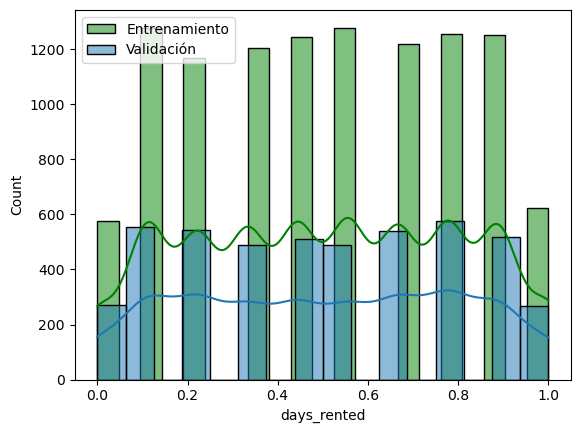

In [24]:
sns.histplot(data=y_train, x='days_rented', kde=True, color='green', label='Entrenamiento')
sns.histplot(y_test, kde=True, color='red', label='Validación')
plt.legend()
plt.show()

Con la gráfica anterior nos aseguramos que los datos de entrenamiento y validación tienen un comportamiento similar.

### Modelo de Regresión Lineal

In [25]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(X_train, y_train)

LinearRegression()

In [26]:
linear_model.coef_

array([[ 5.59183389e-02,  1.38511521e+00, -4.83312979e-01,
         5.18748270e-04,  7.44118997e-03, -1.12687409e-02]])

In [27]:
linear_model.intercept_

array([0.27823989])

In [28]:
max_price = df_rental_reg['days_rented'].max()
min_price = df_rental_reg['days_rented'].min()

In [29]:
# Predecir las variables tanto de entrenamiento como de prueba
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)

# Pasar los datos reales a escala real
y_train = y_train * (max_price - min_price) + min_price
y_test = y_test * (max_price - min_price) + min_price

# Pasar los datos predichos a la escala real
y_pred_train = y_pred_train * (max_price - min_price) + min_price
y_pred_test = y_pred_test * (max_price - min_price) + min_price

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
r2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print(f'''
Las métricas de desempeño son para los datos de entrenamiento son:
      R2: {r2_train}
      RMSE: {rmse_train}
      MAE: {mae_train}
      MAPE: {mape_train}
''')


Las métricas de desempeño son para los datos de entrenamiento son:
      R2: 0.5680770932793031
      RMSE: 1.725077211613898
      MAE: 1.4181914450042001
      MAPE: 714820505077998.9



In [31]:
r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f'''
Las métricas de desempeño son para los datos de validación son:
      R2: {r2_test}
      RMSE: {rmse_test}
      MAE: {mae_test}
      MAPE: {mape_test}
''')


Las métricas de desempeño son para los datos de validación son:
      R2: 0.5669108040246642
      RMSE: 1.7495170655042753
      MAE: 1.4412787759202101
      MAPE: 785387530608107.5



El modelo de regresión lineal utilizado tiene un MAE dentro de lo esperado (menor a 3). Es decir, el promedio de las diferencias absolutas entre los valores reales y los valores predichos por el modelo es de 1.416 días.

### Random Forest Regressor

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [33]:
max_price = df_rental_reg['days_rented'].max()
min_price = df_rental_reg['days_rented'].min()

In [34]:
# Predecir las variables tanto de entrenamiento como de prueba
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)

# Pasar los datos reales a escala real
y_train = y_train * (max_price - min_price) + min_price
y_test = y_test * (max_price - min_price) + min_price

# Pasar los datos predichos a la escala real
y_pred_train = y_pred_train * (max_price - min_price) + min_price
y_pred_test = y_pred_test * (max_price - min_price) + min_price

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
r2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print(f'''
Las métricas de desempeño son para los datos de entrenamiento son:
      R2: {r2_train}
      RMSE: {rmse_train}
      MAE: {mae_train}
      MAPE: {mape_train}
''')


Las métricas de desempeño son para los datos de entrenamiento son:
      R2: -2.2400791151786748
      RMSE: 42.52318015781726
      MAE: 36.60351865444127
      MAPE: 714820505077999.1



In [36]:
r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f'''
Las métricas de desempeño son para los datos de validación son:
      R2: {r2_test}
      RMSE: {rmse_test}
      MAE: {mae_test}
      MAPE: {mape_test}
''')


Las métricas de desempeño son para los datos de validación son:
      R2: -2.1484213118978497
      RMSE: 42.45398278160598
      MAE: 36.36435506023002
      MAPE: 785387530608107.6



El modelo de random forest de regresión utilizado tiene un MAE de 36.45 días, lo cual es muy por encima de lo esperado, mostrando que los valores predichos versus los valores reales tienen una diferencia promedio de 36.45 días. Esta diferencia tan grande hace que este modelo no pueda ser tomado en cuenta para la predicción de la variable de días rentado.

Conclusión: 
- La empresa de alquiler de DVD puede utilizar el modelo de regresión lineal simple para averiguar durante cuántos días alquilará un cliente un DVD basándose en algunas características, ya que este es el que mejor predice de los modelos explorados; además tiene un MSE por debajo de lo esperado.

## Fin